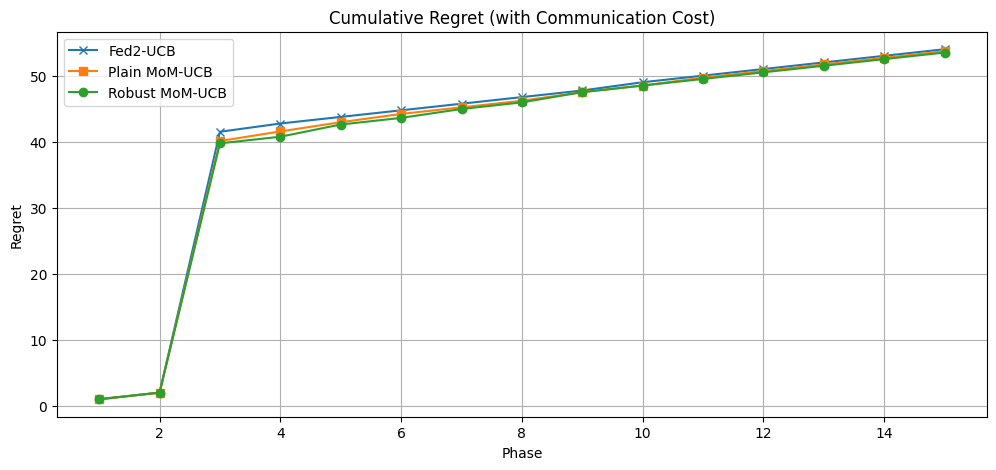

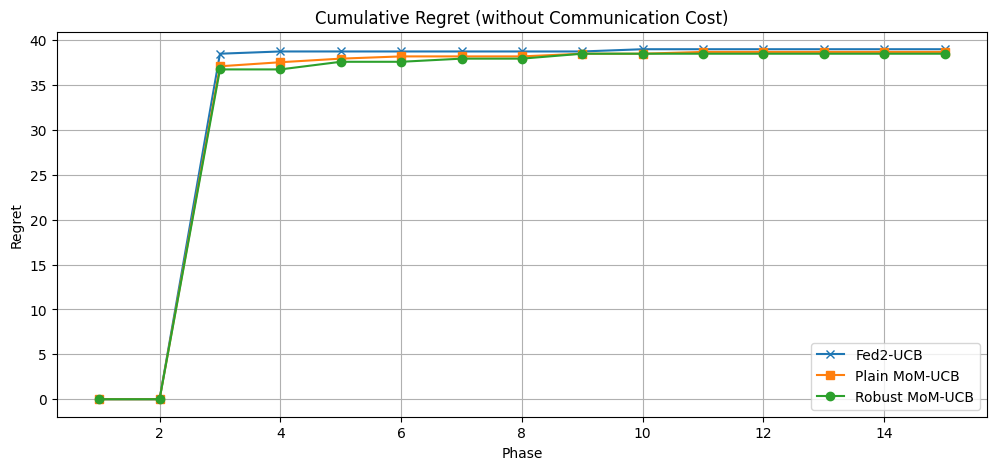

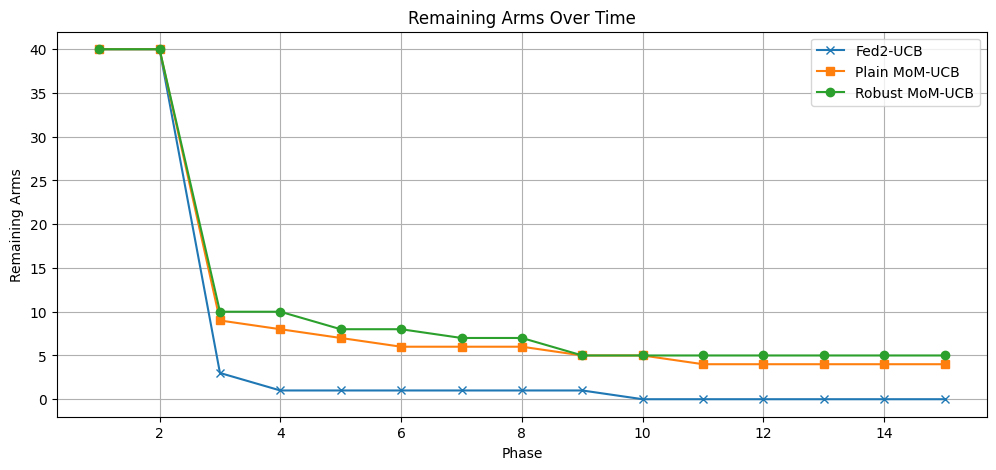

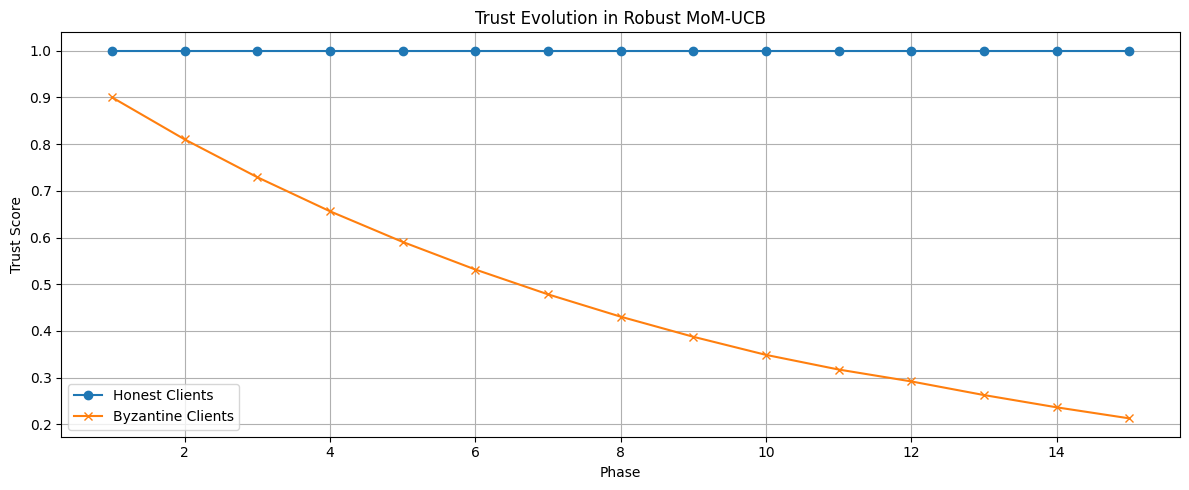

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

np.random.seed(None)

# ------------------- CONFIG -------------------
K = 40
NUM_CLIENTS = 100
LAMBDA = 0.1
SIGMA_C = np.sqrt(0.022)
SIGMA = np.sqrt(2)
GLOBAL_MEANS = np.arange(K) * 0.05

TRIM_RATIO = 0.1
TRUST_DECAY = 0.9
MIN_TRUST = 0.1
DEV_THRESHOLD = 5.0  # Increased from 3.0
PHASES = 15
PULLS_PER_PHASE = 10
COMM_COST = 1.0
ALPHA = np.sqrt(2 * LAMBDA)
B = max(1, int(1 / ALPHA))
G = NUM_CLIENTS // B

# ------------------- ENVIRONMENT -------------------
class BanditEnvironment:
    def __init__(self, local_means):
        self.means = local_means

    def sample(self, arm):
        return np.random.normal(self.means[arm], SIGMA)

# ------------------- CLIENT -------------------
class Client:
    def __init__(self, cid, env, is_byzantine=False):
        self.id = cid
        self.env = env
        self.is_byzantine = is_byzantine
        self.rewards = defaultdict(list)

    def pull(self, active_arms, pulls_per_arm):
        updates = {}
        for arm in active_arms:
            if self.is_byzantine:
                val = np.random.choice([-20.0, 20.0])
                updates[arm] = np.clip(val, -5, 5)  # Clip extreme Byzantine update
            else:
                samples = [self.env.sample(arm) for _ in range(pulls_per_arm)]
                self.rewards[arm].extend(samples)
                updates[arm] = np.mean(self.rewards[arm])
        return updates

# ------------------- BASE SERVER -------------------
class Fed2UCBServer:
    def __init__(self, clients):
        self.clients = clients
        self.active_arms = list(range(K))
        self.comm_rounds = 0
        self.regret_history = []
        self.regret_no_comm_history = []
        self.arm_count_history = []

    def collect_updates(self, pulls_per_arm):
        self.comm_rounds += 1
        return {c.id: c.pull(self.active_arms, pulls_per_arm) for c in self.clients}

    def aggregate(self, updates):
        estimates = {}
        for arm in self.active_arms:
            vals = [updates[cid][arm] for cid in updates if arm in updates[cid]]
            if vals:
                estimates[arm] = np.mean(vals)
        return estimates

    def eliminate_arms(self, estimates, phase):
      if phase < 3:  # Delay elimination
          return
      if not estimates:
          return

      # More lenient elimination threshold
      ep = 2 * SIGMA / np.sqrt(PULLS_PER_PHASE * NUM_CLIENTS * phase)  # Increased margin for uncertainty
      max_est = max(estimates.values())

      # Instead of eliminating arms too aggressively, we compare with a softer threshold
      self.active_arms = [
          k for k in self.active_arms if estimates.get(k, -np.inf) + ep >= max_est - ep and np.random.rand() > 0.1
      ]

    def update_metrics(self):
        regret = sum((max(GLOBAL_MEANS) - GLOBAL_MEANS[k]) for k in range(K) if k not in self.active_arms)
        self.regret_history.append(regret + COMM_COST * self.comm_rounds)
        self.regret_no_comm_history.append(regret)
        self.arm_count_history.append(len(self.active_arms))

    def run(self, phases, pulls_per_arm):
        for p in range(1, phases + 1):
            updates = self.collect_updates(pulls_per_arm)
            estimates = self.aggregate(updates)
            self.eliminate_arms(estimates, p)
            self.update_metrics()

# ------------------- Plain MoM-UCB -------------------
class PlainMoMServer(Fed2UCBServer):
    def form_groups(self, phase):
        np.random.seed(phase)
        ids = [c.id for c in self.clients]
        np.random.shuffle(ids)
        return [ids[i * B:(i + 1) * B] for i in range(G)]

    def aggregate(self, updates, phase=None):
        groups = self.form_groups(phase or 1)
        arm_group_means = defaultdict(list)
        for group in groups:
            for arm in self.active_arms:
                raw_vals = [updates[cid][arm] for cid in group]
                if raw_vals:
                    arm_group_means[arm].append(np.mean(raw_vals))
        return {arm: np.median(vals) for arm, vals in arm_group_means.items()}

    def eliminate_arms(self, estimates, phase):
      if phase < 3:
          return
      if not estimates:
          return
      ep = 1.5 * SIGMA / np.sqrt(PULLS_PER_PHASE * B * phase)
      max_est = max(estimates.values())
      self.active_arms = [
          k for k in self.active_arms if estimates.get(k, -np.inf) + ep >= max_est - ep
      ]

# ------------------- Robust MoM-UCB (Trust + Trimming) -------------------
class RobustMoMServer(PlainMoMServer):
    def __init__(self, clients):
        super().__init__(clients)
        self.client_ids = [c.id for c in clients]
        self.trust = {c.id: 1.0 for c in clients}
        self.trust_history = []
        self.byzantine_ids = {c.id for c in clients if c.is_byzantine}

    def aggregate(self, updates, phase):
        groups = self.form_groups(phase)
        arm_group_means = defaultdict(list)
        for group in groups:
            for arm in self.active_arms:
                raw_vals = [updates[cid][arm] for cid in group]
                trusts = [self.trust[cid] for cid in group]
                weighted = [v * t for v, t in zip(raw_vals, trusts)]
                n = len(raw_vals)
                t = int(n * TRIM_RATIO)
                idx = np.argsort(raw_vals)
                keep = idx[t:n - t] if n > 2 * t else idx
                tv = [weighted[i] for i in keep]
                tw = [trusts[i] for i in keep]
                mean = sum(tv) / sum(tw) if tw else 0.0
                arm_group_means[arm].append(mean)
        return {arm: np.median(vals) for arm, vals in arm_group_means.items()}

    def update_trust(self, updates, global_est):
        for cid in self.client_ids:
            for arm in self.active_arms:
                if abs(updates[cid][arm] - global_est[arm]) > DEV_THRESHOLD:
                    self.trust[cid] = max(self.trust[cid] * TRUST_DECAY, MIN_TRUST)
                    break

    def eliminate_arms(self, estimates, phase):
        if phase < 3:  # Avoid early elimination
            return
        if not estimates:
            return
        ep = 1.5 * SIGMA / np.sqrt(PULLS_PER_PHASE * B * phase)
        max_est = max(estimates.values())
        self.active_arms = [k for k in self.active_arms if estimates.get(k, -np.inf) + ep >= max_est - ep]

    def update_metrics(self):
        super().update_metrics()
        self.trust_history.append([self.trust[cid] for cid in self.client_ids])

    def run(self, phases, pulls_per_arm):
        for p in range(1, phases + 1):
            updates = self.collect_updates(pulls_per_arm)
            estimates = self.aggregate(updates, p)
            self.update_trust(updates, estimates)
            self.eliminate_arms(estimates, p)
            self.update_metrics()

# ------------------- SETUP CLIENTS -------------------
client_ids = list(range(NUM_CLIENTS))
byz_ids = set(np.random.choice(client_ids, int(LAMBDA * NUM_CLIENTS), replace=False))
make_clients = lambda: [Client(cid, BanditEnvironment(GLOBAL_MEANS + np.random.normal(0, SIGMA_C, K)), is_byzantine=(cid in byz_ids)) for cid in client_ids]
clients_fed2 = make_clients()
clients_mom = make_clients()
clients_robust = make_clients()

# ------------------- RUN -------------------
fed2 = Fed2UCBServer(clients_fed2)
mom = PlainMoMServer(clients_mom)
robust = RobustMoMServer(clients_robust)

fed2.run(PHASES, PULLS_PER_PHASE)
mom.run(PHASES, PULLS_PER_PHASE)
robust.run(PHASES, PULLS_PER_PHASE)

# ------------------- PLOTS -------------------
x = np.arange(1, PHASES + 1)

plt.figure(figsize=(12, 5))
plt.plot(x, fed2.regret_history, label='Fed2-UCB', marker='x')
plt.plot(x, mom.regret_history, label='Plain MoM-UCB', marker='s')
plt.plot(x, robust.regret_history, label='Robust MoM-UCB', marker='o')
plt.title("Cumulative Regret (with Communication Cost)")
plt.xlabel("Phase"); plt.ylabel("Regret"); plt.legend(); plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(x, fed2.regret_no_comm_history, label='Fed2-UCB', marker='x')
plt.plot(x, mom.regret_no_comm_history, label='Plain MoM-UCB', marker='s')
plt.plot(x, robust.regret_no_comm_history, label='Robust MoM-UCB', marker='o')
plt.title("Cumulative Regret (without Communication Cost)")
plt.xlabel("Phase"); plt.ylabel("Regret"); plt.legend(); plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(x, fed2.arm_count_history, label='Fed2-UCB', marker='x')
plt.plot(x, mom.arm_count_history, label='Plain MoM-UCB', marker='s')
plt.plot(x, robust.arm_count_history, label='Robust MoM-UCB', marker='o')
plt.title("Remaining Arms Over Time")
plt.xlabel("Phase"); plt.ylabel("Remaining Arms"); plt.legend(); plt.grid()

honest_trust = [np.mean([t for i, t in enumerate(tr) if i not in byz_ids]) for tr in robust.trust_history]
byz_trust = [np.mean([t for i, t in enumerate(tr) if i in byz_ids]) for tr in robust.trust_history]

plt.figure(figsize=(12, 5))
plt.plot(x, honest_trust, label='Honest Clients', marker='o')
plt.plot(x, byz_trust, label='Byzantine Clients', marker='x')
plt.title("Trust Evolution in Robust MoM-UCB")
plt.xlabel("Phase"); plt.ylabel("Trust Score"); plt.legend(); plt.grid()

plt.tight_layout()
plt.show()
